# YOLOv9 Model Comparison & Evaluation
## Fine-tuned vs Baseline Performance Analysis

This notebook evaluates and compares:
1. **Fine-tuned YOLOv9** - Trained on your parking dataset with COCO pretrained weights
2. **Pretrained baseline (COCO)** - Original YOLOv9-c with COCO weights (no fine-tuning)
3. **From-scratch** - Trained without pretrained weights (optional)

**Metrics evaluated:**
- Detection accuracy (mAP@0.5, mAP@0.5:0.95, Precision, Recall)
- Counting accuracy (Exact Match, MAE)
- Inference speed (FPS, latency)
- Model size and memory usage

## 1. Setup and Imports

In [1]:
import os
import sys
import subprocess
import yaml
import re
import json
import time
import shutil
from pathlib import Path
from collections import defaultdict

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 2070


## 2. Configuration

In [2]:
# Paths
YOLOV9_DIR = Path('./yolov9')
DATA_YAML = Path('./prepared_data/yolo/data.yaml')
FINETUNED_WEIGHTS = Path('./runs/train/carpk_yolov9/weights/best.pt')
PRETRAINED_WEIGHTS = Path('./yolov9/weights/yolov9-c.pt')  # Original COCO weights
SCRATCH_WEIGHTS = Path('./runs/train/carpk_yolov9_scratch/weights/best.pt')  # Optional

# Evaluation settings
IMG_SIZE = 640
CONF_THRESHOLD = 0.25
IOU_THRESHOLD = 0.7
DEVICE = '0' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4

# Benchmark settings
WARMUP_ITERATIONS = 10
BENCHMARK_ITERATIONS = 100

print(f"YOLOv9 Directory: {YOLOV9_DIR}")
print(f"Data YAML: {DATA_YAML}")
print(f"Fine-tuned weights: {FINETUNED_WEIGHTS}")
print(f"Pretrained weights: {PRETRAINED_WEIGHTS}")
print(f"Device: {DEVICE}")

# Verify files exist
if not YOLOV9_DIR.exists():
    raise FileNotFoundError(f"YOLOv9 directory not found: {YOLOV9_DIR}")
if not DATA_YAML.exists():
    raise FileNotFoundError(f"Data YAML not found: {DATA_YAML}")
if not FINETUNED_WEIGHTS.exists():
    print(f"Warning: Fine-tuned weights not found: {FINETUNED_WEIGHTS}")
if not PRETRAINED_WEIGHTS.exists():
    print(f"Warning: Pretrained weights not found: {PRETRAINED_WEIGHTS}")

YOLOv9 Directory: yolov9
Data YAML: prepared_data\yolo\data.yaml
Fine-tuned weights: runs\train\carpk_yolov9\weights\best.pt
Pretrained weights: yolov9\weights\yolov9-c.pt
Device: 0


## 3. Create COCO-Compatible Data YAML

The pretrained COCO model expects 80 classes, but our dataset only has 1 (car).
We'll create a special data.yaml that maps COCO's car class (class 2) to our data.

In [3]:
def create_coco_compatible_yaml(original_yaml_path):
    """
    Create a COCO-compatible data.yaml for pretrained model evaluation
    """
    # Read original data.yaml
    with open(original_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # COCO class names (80 classes)
    coco_names = [
        'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
        'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]
    
    # Create COCO-compatible config
    coco_config = {
        'path': str(original_yaml_path.parent.absolute()),
        'train': data_config.get('train', 'train/images'),
        'val': data_config.get('val', 'val/images'),
        'test': data_config.get('test', 'test/images'),
        'nc': 80,  # COCO has 80 classes
        'names': coco_names
    }
    
    # Save to temporary file
    coco_yaml_path = original_yaml_path.parent / 'data_coco.yaml'
    with open(coco_yaml_path, 'w') as f:
        yaml.dump(coco_config, f, default_flow_style=False)
    
    print(f"Created COCO-compatible data.yaml at: {coco_yaml_path}")
    print(f"  COCO 'car' is class index 2")
    print(f"  Will filter predictions to only include 'car' detections")
    
    return coco_yaml_path

# Create COCO-compatible YAML
COCO_DATA_YAML = create_coco_compatible_yaml(DATA_YAML)

Created COCO-compatible data.yaml at: prepared_data\yolo\data_coco.yaml
  COCO 'car' is class index 2
  Will filter predictions to only include 'car' detections


## 4. Helper Functions

In [4]:
def run_yolo_validation(weights_path, model_name, data_yaml, yolov9_dir, device='0', is_coco_model=False):
    """
    Run YOLOv9 validation and extract metrics
    
    Args:
        is_coco_model: If True, will use COCO-compatible data.yaml and filter for car class
    """
    print(f"\n{'='*70}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*70}")
    print(f"Weights: {weights_path}")
    if is_coco_model:
        print(f"Note: Using COCO model - will filter for 'car' class (index 2)")
    
    original_dir = Path.cwd()
    abs_weights = weights_path.resolve()
    abs_data_yaml = data_yaml.resolve()
    
    try:
        os.chdir(yolov9_dir)
        
        cmd = [
            sys.executable, 'val.py',
            '--data', str(abs_data_yaml),
            '--weights', str(abs_weights),
            '--img', str(IMG_SIZE),
            '--conf-thres', '0.001',
            '--iou-thres', str(IOU_THRESHOLD),
            '--device', device,
            '--task', 'test',
            '--verbose'
        ]
        
        if is_coco_model:
            cmd.extend(['--single-cls'])  # Treat all classes as one for evaluation
        
        print("\nRunning validation...")
        result = subprocess.run(cmd, capture_output=True, text=True, encoding='utf-8', errors='replace')
        
        if result.returncode != 0:
            print(f"Warning: Validation failed with return code {result.returncode}")
            print(result.stderr)
            return None
        
        full_output = result.stdout + "\n" + result.stderr
        
        # Parse metrics
        metrics = {}
        
        # Extract mAP, precision, recall
        all_class_line = re.search(r"all\s+\d+\s+\d+\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)", full_output)
        if all_class_line:
            metrics['precision'] = float(all_class_line.group(1))
            metrics['recall'] = float(all_class_line.group(2))
            metrics['map_50'] = float(all_class_line.group(3))
            metrics['map_50_95'] = float(all_class_line.group(4))
        
        # Extract speed metrics
        speed_patterns = [
            r"Speed:.*?([\d\.]+)ms\s+inference",
            r"inference:\s*([\d\.]+)ms",
            r"([\d\.]+)ms.*?inference"
        ]
        
        for pattern in speed_patterns:
            speed_line = re.search(pattern, full_output, re.IGNORECASE)
            if speed_line:
                inference_ms = float(speed_line.group(1))
                if inference_ms > 0:
                    metrics['inference_ms'] = inference_ms
                    metrics['fps'] = 1000.0 / inference_ms
                break
        
        print("\nDetection Metrics:")
        for key, val in metrics.items():
            if key == 'fps' or key == 'inference_ms':
                print(f"  {key}: {val:.2f}")
            else:
                print(f"  {key}: {val:.4f}")
        
        return metrics
        
    finally:
        os.chdir(original_dir)


def get_test_directories(data_yaml):
    """
    Extract test image and label directories from data.yaml
    """
    abs_data_yaml = data_yaml.resolve()
    
    with open(abs_data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    test_path_str = data_config.get('test', '')
    if not test_path_str:
        raise ValueError("'test' key not found in data.yaml")
    
    test_path = (abs_data_yaml.parent / test_path_str).resolve()
    
    # Handle different directory structures
    if test_path.name == 'images' and test_path.exists():
        test_img_dir = test_path
        gt_label_dir = test_path.parent / 'labels'
    elif (test_path / 'images').exists():
        test_img_dir = test_path / 'images'
        gt_label_dir = test_path / 'labels'
    else:
        test_img_dir = test_path
        gt_label_dir = test_path.with_name('labels')
        if not gt_label_dir.exists():
            gt_label_dir = test_path.parent / 'labels'
    
    return test_img_dir, gt_label_dir


def deduplicate_predictions(pred_label_dir):
    """
    Remove duplicate predictions from label files
    """
    label_files = list(pred_label_dir.glob('*.txt'))
    total_before = 0
    total_after = 0
    
    for label_file in label_files:
        if not label_file.exists():
            continue
            
        with open(label_file, 'r') as f:
            lines = f.readlines()
        
        total_before += len(lines)
        
        unique_lines = []
        seen = set()
        
        for line in lines:
            line = line.strip()
            if line and line not in seen:
                unique_lines.append(line)
                seen.add(line)
        
        total_after += len(unique_lines)
        
        with open(label_file, 'w') as f:
            f.write('\n'.join(unique_lines) + '\n' if unique_lines else '')
    
    if total_before > total_after:
        print(f"  Removed {total_before - total_after} duplicate detections")


def filter_car_class_only(pred_label_dir, car_class_id=2):
    """
    Filter predictions to only keep 'car' class (class 2 in COCO)
    and renumber to class 0 for our single-class dataset
    """
    label_files = list(pred_label_dir.glob('*.txt'))
    total_before = 0
    total_after = 0
    
    for label_file in label_files:
        if not label_file.exists():
            continue
        
        with open(label_file, 'r') as f:
            lines = f.readlines()
        
        total_before += len(lines)
        
        filtered_lines = []
        for line in lines:
            parts = line.strip().split()
            if parts and int(parts[0]) == car_class_id:
                # Change class ID to 0 (our car class)
                parts[0] = '0'
                filtered_lines.append(' '.join(parts))
        
        total_after += len(filtered_lines)
        
        with open(label_file, 'w') as f:
            f.write('\n'.join(filtered_lines) + '\n' if filtered_lines else '')
    
    print(f"  Filtered to car class only: {total_before} -> {total_after} predictions")


def run_yolo_detection(weights_path, model_name, yolov9_dir, output_name, is_coco_model=False):
    """
    Run YOLOv9 detection and return prediction directory
    """
    print(f"\nRunning detection for {model_name}...")
    
    original_dir = Path.cwd()
    abs_weights = weights_path.resolve()
    test_img_dir, _ = get_test_directories(DATA_YAML)
    
    project_dir = original_dir / 'runs' / 'detect_comparison'
    pred_label_dir = project_dir / output_name / 'labels'
    
    # Clean up previous run
    if (project_dir / output_name).exists():
        shutil.rmtree(project_dir / output_name)
    
    try:
        os.chdir(yolov9_dir)
        
        cmd = [
            sys.executable, 'detect.py',
            '--weights', str(abs_weights),
            '--source', str(test_img_dir),
            '--img', str(IMG_SIZE),
            '--conf', str(CONF_THRESHOLD),
            '--iou-thres', str(IOU_THRESHOLD),
            '--device', DEVICE,
            '--save-txt',
            '--project', str(project_dir),
            '--name', output_name
        ]
        
        subprocess.run(cmd, check=True, capture_output=True, text=True, encoding='utf-8', errors='replace')
        
        # For COCO model, filter to only car class
        if is_coco_model:
            filter_car_class_only(pred_label_dir, car_class_id=2)
        
        # Deduplicate predictions
        deduplicate_predictions(pred_label_dir)
        
        return pred_label_dir
        
    except subprocess.CalledProcessError as e:
        print(f"  Warning: Detection failed: {e.stderr}")
        return None
    finally:
        os.chdir(original_dir)


def calculate_counting_metrics(pred_label_dir, model_name):
    """
    Calculate counting accuracy and MAE
    """
    print(f"\nCalculating counting metrics for {model_name}...")
    
    test_img_dir, gt_label_dir = get_test_directories(DATA_YAML)
    
    if not gt_label_dir.exists():
        raise FileNotFoundError(f"Ground truth label directory not found: {gt_label_dir}")
    
    test_images = list(test_img_dir.glob('*.jpg')) + list(test_img_dir.glob('*.png'))
    if not test_images:
        raise ValueError(f"No images found in {test_img_dir}")
    
    results = []
    
    for img_path in tqdm(test_images, desc=f"Counting ({model_name})"):
        gt_label_path = gt_label_dir / f"{img_path.stem}.txt"
        pred_label_path = pred_label_dir / f"{img_path.stem}.txt"
        
        gt_count = 0
        if gt_label_path.exists():
            with open(gt_label_path, 'r') as f:
                gt_count = sum(1 for line in f if line.strip())
        
        pred_count = 0
        if pred_label_path.exists():
            with open(pred_label_path, 'r') as f:
                pred_count = sum(1 for line in f if line.strip())
        
        results.append({
            'image': img_path.name,
            'gt_count': gt_count,
            'pred_count': pred_count,
            'difference': pred_count - gt_count,
            'abs_error': abs(pred_count - gt_count)
        })
    
    df = pd.DataFrame(results)
    
    correct_counts = (df['difference'] == 0).sum()
    total_images = len(df)
    exact_accuracy = (correct_counts / total_images) * 100
    mae = df['abs_error'].mean()
    
    print(f"  Exact Accuracy: {exact_accuracy:.2f}%")
    print(f"  MAE: {mae:.4f}")
    
    return {'count_accuracy': exact_accuracy, 'count_mae': mae}, df


def get_model_size(weights_path):
    """
    Get model file size in MB
    """
    if weights_path.exists():
        size_mb = weights_path.stat().st_size / (1024**2)
        return size_mb
    return 0

print("Helper functions loaded.")

Helper functions loaded.


## 5. Run Evaluation for All Models

In [5]:
results = {}

# Define models to evaluate
models_to_eval = []

if FINETUNED_WEIGHTS.exists():
    models_to_eval.append(('Fine-tuned', FINETUNED_WEIGHTS, 'finetuned', DATA_YAML, False))
else:
    print(f"Warning: Skipping fine-tuned model (weights not found)")

if PRETRAINED_WEIGHTS.exists():
    # Use COCO-compatible YAML for pretrained model
    models_to_eval.append(('Pretrained (COCO)', PRETRAINED_WEIGHTS, 'pretrained', COCO_DATA_YAML, True))
else:
    print(f"Warning: Skipping pretrained baseline (weights not found)")

if SCRATCH_WEIGHTS.exists():
    models_to_eval.append(('From Scratch', SCRATCH_WEIGHTS, 'scratch', DATA_YAML, False))

print(f"\nEvaluating {len(models_to_eval)} models...\n")

# Evaluate each model
for model_name, weights_path, output_name, data_yaml, is_coco in models_to_eval:
    print(f"\n{'='*70}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*70}")
    
    # 1. Detection metrics (mAP, precision, recall, FPS)
    print("\n[1/3] Detection metrics...")
    detection_metrics = run_yolo_validation(
        weights_path, model_name, data_yaml, YOLOV9_DIR, DEVICE, is_coco_model=is_coco
    )
    
    if detection_metrics is None:
        print(f"  Warning: Skipping {model_name} due to validation failure")
        continue
    
    # 2. Run detection for counting metrics
    print(f"\n[2/3] Running detection for counting...")
    pred_label_dir = run_yolo_detection(
        weights_path, model_name, YOLOV9_DIR, output_name, is_coco_model=is_coco
    )
    
    if pred_label_dir is None:
        print(f"  Warning: Detection failed for {model_name}")
        counting_metrics = {'count_accuracy': 0, 'count_mae': 0}
        count_df = pd.DataFrame()
    else:
        # 3. Counting metrics
        print(f"\n[3/3] Counting metrics...")
        counting_metrics, count_df = calculate_counting_metrics(pred_label_dir, model_name)
    
    # Get model size
    model_size_mb = get_model_size(weights_path)
    
    # Store results
    results[model_name] = {
        'detection': detection_metrics,
        'counting': counting_metrics,
        'count_df': count_df,
        'model_size_mb': model_size_mb
    }
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"{model_name} - Summary")
    print(f"{'='*70}")
    print(f"Detection:")
    print(f"  mAP@0.5:0.95: {detection_metrics.get('map_50_95', 0):.4f}")
    print(f"  mAP@0.5:      {detection_metrics.get('map_50', 0):.4f}")
    print(f"  Precision:    {detection_metrics.get('precision', 0):.4f}")
    print(f"  Recall:       {detection_metrics.get('recall', 0):.4f}")
    print(f"\nCounting:")
    print(f"  Accuracy:     {counting_metrics['count_accuracy']:.2f}%")
    print(f"  MAE:          {counting_metrics['count_mae']:.4f}")
    print(f"\nSpeed:")
    print(f"  FPS:          {detection_metrics.get('fps', 0):.2f}")
    print(f"  Latency:      {detection_metrics.get('inference_ms', 0):.2f} ms")
    print(f"\nResources:")
    print(f"  Model size:   {model_size_mb:.2f} MB")
    print(f"{'='*70}\n")

print("\nAll evaluations complete!")


Evaluating 2 models...


Evaluating: Fine-tuned

[1/3] Detection metrics...

Evaluating: Fine-tuned
Weights: runs\train\carpk_yolov9\weights\best.pt

Running validation...

Detection Metrics:
  precision: 0.9920
  recall: 0.9960
  map_50: 0.9940
  map_50_95: 0.8710
  inference_ms: 26.30
  fps: 38.02

[2/3] Running detection for counting...

Running detection for Fine-tuned...

[3/3] Counting metrics...

Calculating counting metrics for Fine-tuned...


Counting (Fine-tuned): 100%|██████████| 164/164 [00:00<00:00, 689.22it/s]


  Exact Accuracy: 61.59%
  MAE: 0.6585

Fine-tuned - Summary
Detection:
  mAP@0.5:0.95: 0.8710
  mAP@0.5:      0.9940
  Precision:    0.9920
  Recall:       0.9960

Counting:
  Accuracy:     61.59%
  MAE:          0.6585

Speed:
  FPS:          38.02
  Latency:      26.30 ms

Resources:
  Model size:   325.39 MB


Evaluating: Pretrained (COCO)

[1/3] Detection metrics...

Evaluating: Pretrained (COCO)
Weights: yolov9\weights\yolov9-c.pt
Note: Using COCO model - will filter for 'car' class (index 2)

Running validation...

Detection Metrics:
  precision: 0.7870
  recall: 0.5770
  map_50: 0.7490
  map_50_95: 0.5100
  inference_ms: 30.20
  fps: 33.11

[2/3] Running detection for counting...

Running detection for Pretrained (COCO)...
  Filtered to car class only: 1964 -> 263 predictions

[3/3] Counting metrics...

Calculating counting metrics for Pretrained (COCO)...


Counting (Pretrained (COCO)): 100%|██████████| 164/164 [00:00<00:00, 1429.51it/s]

  Exact Accuracy: 0.00%
  MAE: 41.0427

Pretrained (COCO) - Summary
Detection:
  mAP@0.5:0.95: 0.5100
  mAP@0.5:      0.7490
  Precision:    0.7870
  Recall:       0.5770

Counting:
  Accuracy:     0.00%
  MAE:          41.0427

Speed:
  FPS:          33.11
  Latency:      30.20 ms

Resources:
  Model size:   98.37 MB


All evaluations complete!


## 6. Comparison Tables

In [6]:
# Detection metrics table
detection_data = []
for model_name, result in results.items():
    det = result['detection']
    detection_data.append({
        'Model': model_name,
        'mAP@0.5:0.95': f"{det.get('map_50_95', 0):.4f}",
        'mAP@0.5': f"{det.get('map_50', 0):.4f}",
        'Precision': f"{det.get('precision', 0):.4f}",
        'Recall': f"{det.get('recall', 0):.4f}"
    })

df_detection = pd.DataFrame(detection_data)
print("\n" + "="*80)
print("DETECTION METRICS COMPARISON")
print("="*80)
print(df_detection.to_string(index=False))

# Counting metrics table
counting_data = []
for model_name, result in results.items():
    cnt = result['counting']
    counting_data.append({
        'Model': model_name,
        'Exact Accuracy (%)': f"{cnt['count_accuracy']:.2f}",
        'MAE': f"{cnt['count_mae']:.4f}"
    })

df_counting = pd.DataFrame(counting_data)
print("\n" + "="*80)
print("COUNTING METRICS COMPARISON")
print("="*80)
print(df_counting.to_string(index=False))

# Speed and resources table
resource_data = []
for model_name, result in results.items():
    det = result['detection']
    resource_data.append({
        'Model': model_name,
        'FPS': f"{det.get('fps', 0):.2f}",
        'Latency (ms)': f"{det.get('inference_ms', 0):.2f}",
        'Model Size (MB)': f"{result['model_size_mb']:.2f}"
    })

df_resources = pd.DataFrame(resource_data)
print("\n" + "="*80)
print("SPEED & RESOURCES COMPARISON")
print("="*80)
print(df_resources.to_string(index=False))

# Improvement analysis
if 'Fine-tuned' in results and 'Pretrained (COCO)' in results:
    print("\n" + "="*80)
    print("IMPROVEMENT (Fine-tuned vs Pretrained COCO)")
    print("="*80)
    
    ft = results['Fine-tuned']
    baseline = results['Pretrained (COCO)']
    improvements = []
    
    metrics_to_compare = [
        ('mAP@0.5:0.95', 'map_50_95', 'detection'),
        ('mAP@0.5', 'map_50', 'detection'),
        ('Precision', 'precision', 'detection'),
        ('Recall', 'recall', 'detection'),
        ('Count Accuracy', 'count_accuracy', 'counting'),
        ('Count MAE', 'count_mae', 'counting')
    ]
    
    for metric_name, key, category in metrics_to_compare:
        if category == 'detection':
            ft_val = ft[category].get(key, 0)
            bl_val = baseline[category].get(key, 0)
        else:
            ft_val = ft[category][key]
            bl_val = baseline[category][key]
        
        if bl_val > 0:
            if key == 'count_mae':  # Lower is better
                improvement = ((bl_val - ft_val) / bl_val) * 100
            else:  # Higher is better
                improvement = ((ft_val - bl_val) / bl_val) * 100
        else:
            improvement = float('inf') if ft_val > 0 else 0
        
        improvements.append({
            'Metric': metric_name,
            'Baseline': f"{bl_val:.4f}" if key != 'count_accuracy' else f"{bl_val:.2f}%",
            'Fine-tuned': f"{ft_val:.4f}" if key != 'count_accuracy' else f"{ft_val:.2f}%",
            'Absolute Diff': f"{ft_val - bl_val:+.4f}" if key != 'count_accuracy' else f"{ft_val - bl_val:+.2f}%",
            'Improvement': f"{improvement:+.2f}%" if improvement != float('inf') else 'N/A'
        })
    
    df_improvements = pd.DataFrame(improvements)
    print(df_improvements.to_string(index=False))
    print("="*80)


DETECTION METRICS COMPARISON
            Model mAP@0.5:0.95 mAP@0.5 Precision Recall
       Fine-tuned       0.8710  0.9940    0.9920 0.9960
Pretrained (COCO)       0.5100  0.7490    0.7870 0.5770

COUNTING METRICS COMPARISON
            Model Exact Accuracy (%)     MAE
       Fine-tuned              61.59  0.6585
Pretrained (COCO)               0.00 41.0427

SPEED & RESOURCES COMPARISON
            Model   FPS Latency (ms) Model Size (MB)
       Fine-tuned 38.02        26.30          325.39
Pretrained (COCO) 33.11        30.20           98.37

IMPROVEMENT (Fine-tuned vs Pretrained COCO)
        Metric Baseline Fine-tuned Absolute Diff Improvement
  mAP@0.5:0.95   0.5100     0.8710       +0.3610     +70.78%
       mAP@0.5   0.7490     0.9940       +0.2450     +32.71%
     Precision   0.7870     0.9920       +0.2050     +26.05%
        Recall   0.5770     0.9960       +0.4190     +72.62%
Count Accuracy    0.00%     61.59%       +61.59%         N/A
     Count MAE  41.0427     0.6585    

## 7. Visualization - Detection Metrics

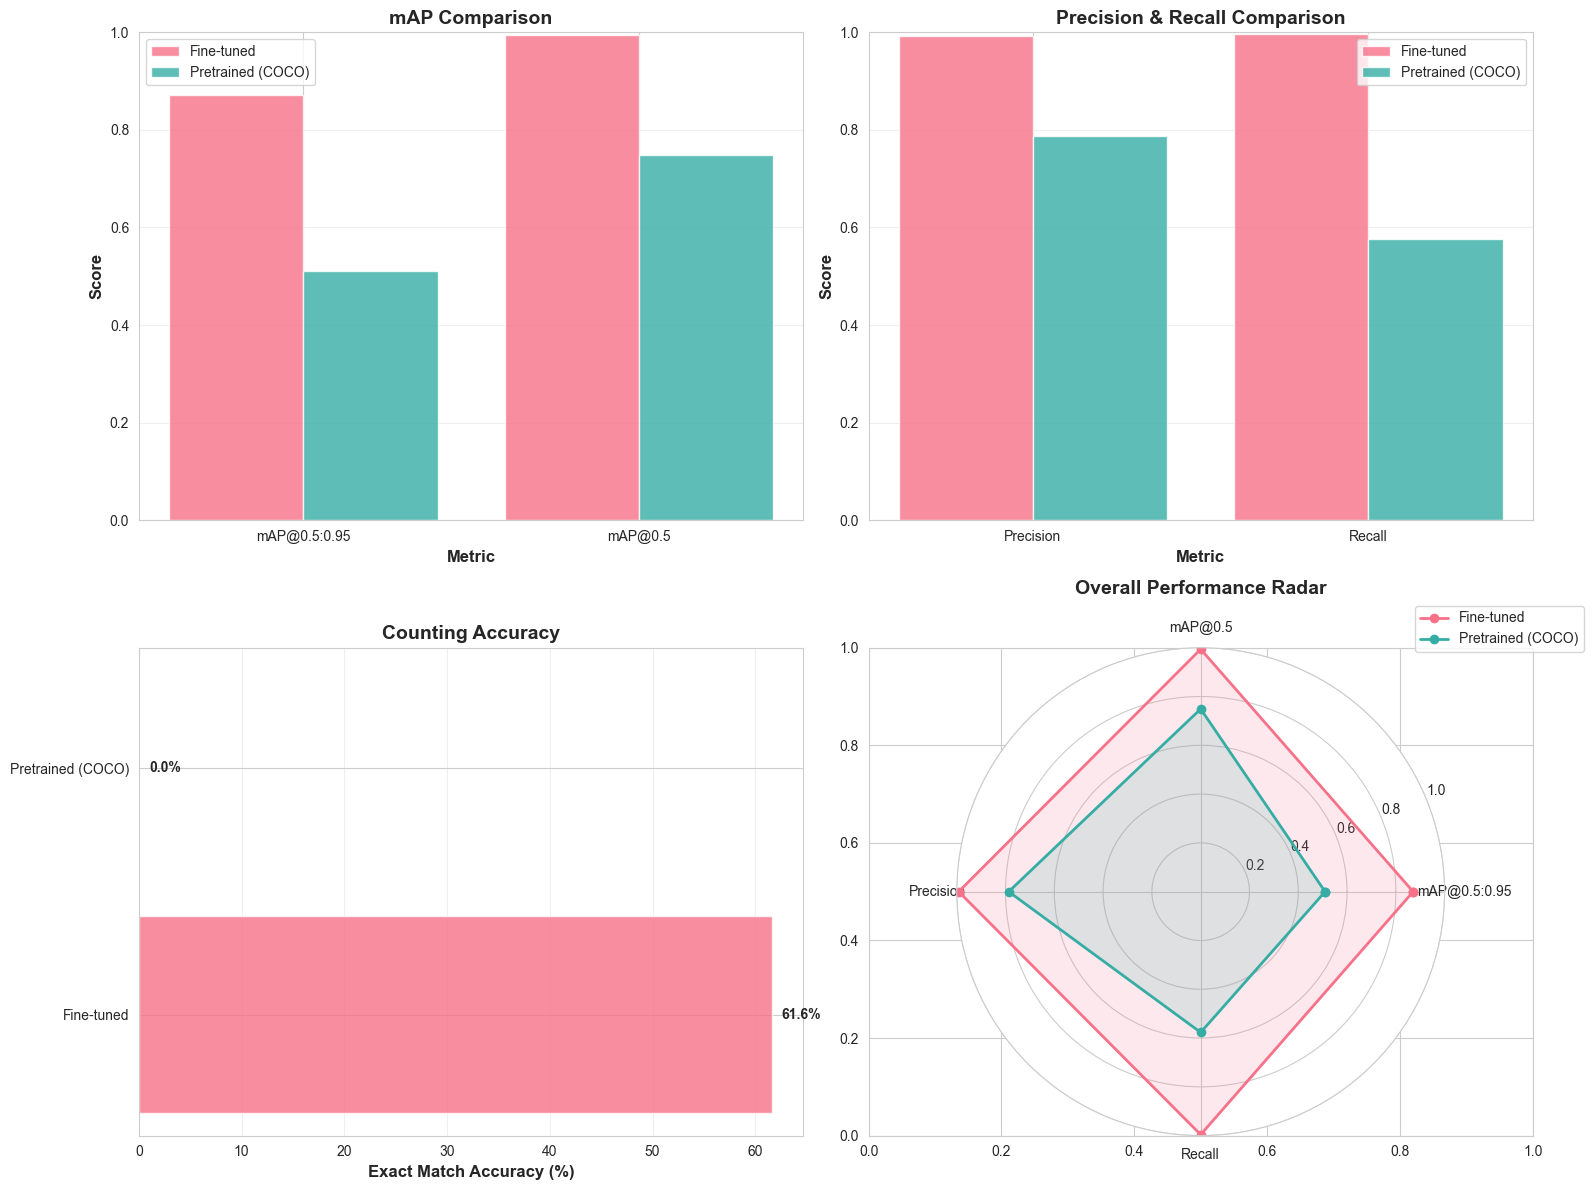

Detection comparison plots saved


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
model_names = list(results.keys())
colors = sns.color_palette("husl", len(model_names))

# mAP comparison
ax = axes[0, 0]
metrics = ['map_50_95', 'map_50']
metric_labels = ['mAP@0.5:0.95', 'mAP@0.5']
x = np.arange(len(metrics))
width = 0.8 / len(model_names)

for i, (model_name, color) in enumerate(zip(model_names, colors)):
    values = [results[model_name]['detection'].get(m, 0) for m in metrics]
    ax.bar(x + i * width, values, width, label=model_name, color=color, alpha=0.8)

ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('mAP Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metric_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

# Precision & Recall
ax = axes[0, 1]
metrics = ['precision', 'recall']
metric_labels = ['Precision', 'Recall']
x = np.arange(len(metrics))

for i, (model_name, color) in enumerate(zip(model_names, colors)):
    values = [results[model_name]['detection'].get(m, 0) for m in metrics]
    ax.bar(x + i * width, values, width, label=model_name, color=color, alpha=0.8)

ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Precision & Recall Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metric_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

# Counting metrics
ax = axes[1, 0]
count_acc = [results[name]['counting']['count_accuracy'] for name in model_names]
bars = ax.barh(model_names, count_acc, color=colors, alpha=0.8)
ax.set_xlabel('Exact Match Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Counting Accuracy', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, count_acc)):
    ax.text(val + 1, i, f'{val:.1f}%', va='center', fontweight='bold')

# Radar chart
ax = plt.subplot(2, 2, 4, projection='polar')
categories = ['mAP@0.5:0.95', 'mAP@0.5', 'Precision', 'Recall']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

for model_name, color in zip(model_names, colors):
    det = results[model_name]['detection']
    values = [
        det.get('map_50_95', 0),
        det.get('map_50', 0),
        det.get('precision', 0),
        det.get('recall', 0)
    ]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Overall Performance Radar', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig('yolov9_detection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Detection comparison plots saved")

## 8. Visualization - Speed & Efficiency

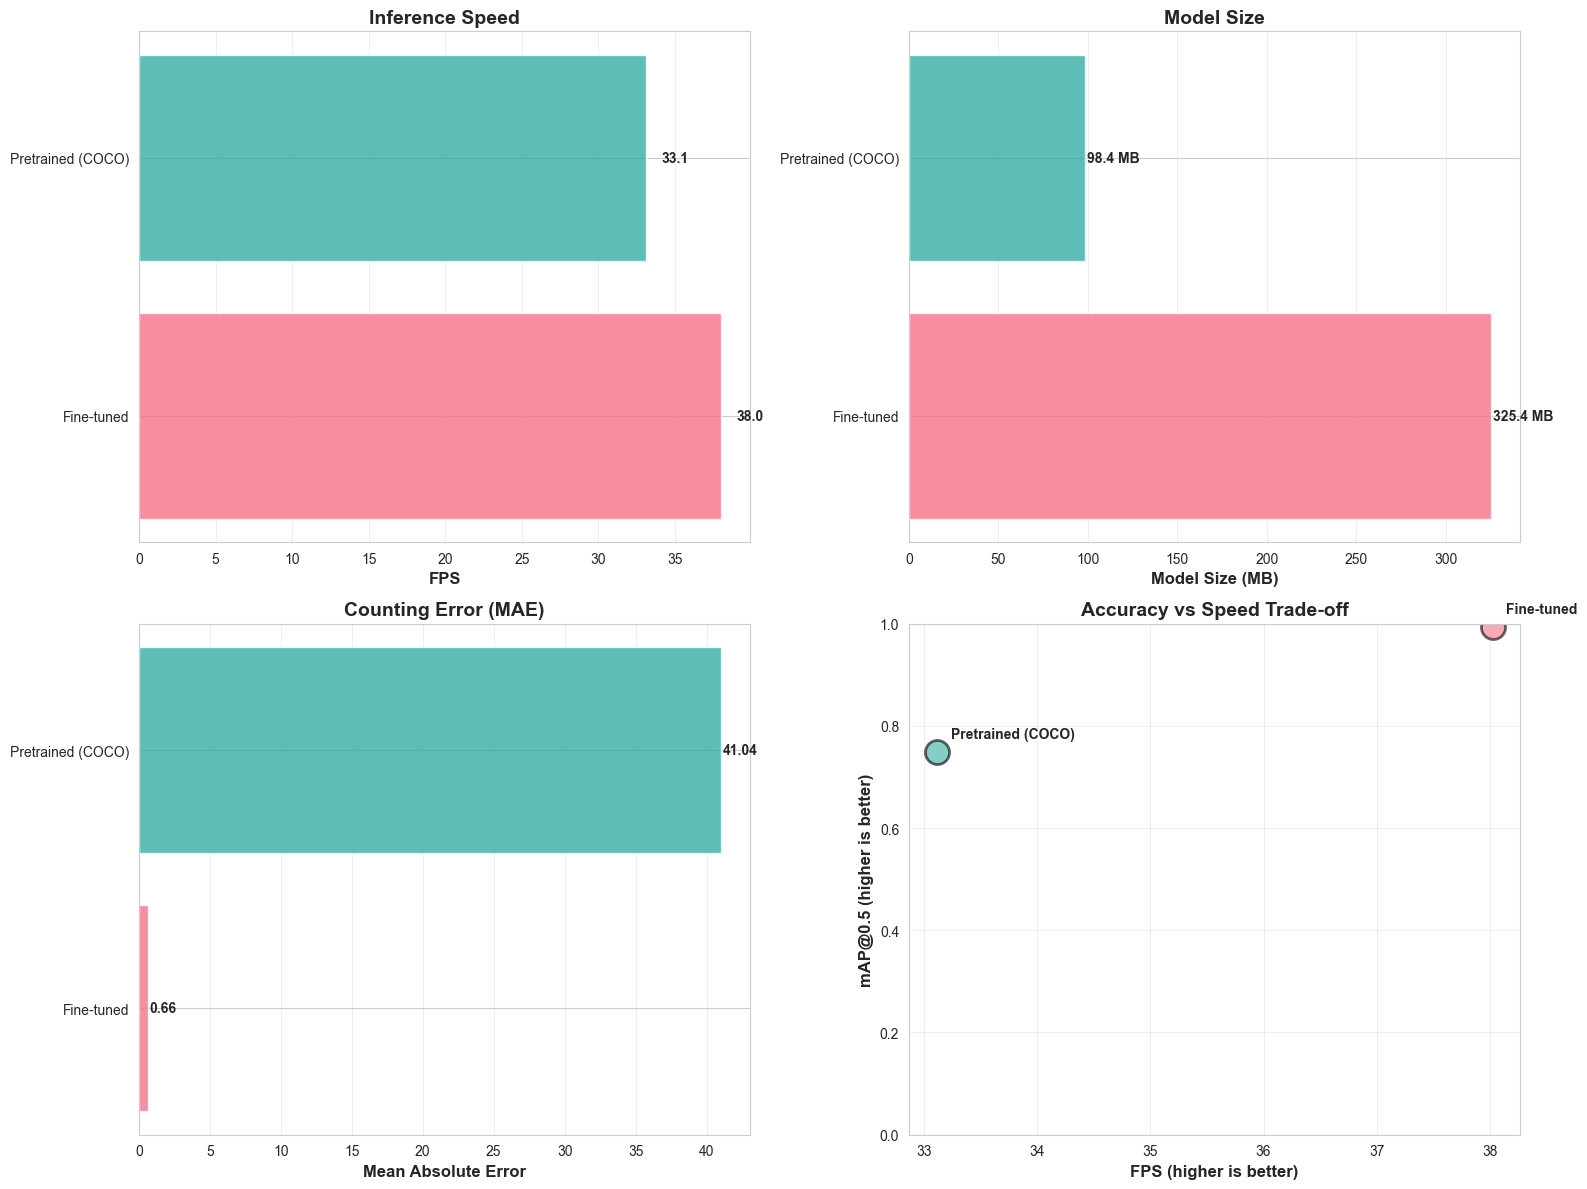

Speed & efficiency plots saved


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# FPS comparison
ax = axes[0, 0]
fps_data = [(name, results[name]['detection'].get('fps', 0)) for name in model_names]
names, fps = zip(*fps_data)
bars = ax.barh(names, fps, color=colors, alpha=0.8)
ax.set_xlabel('FPS', fontsize=12, fontweight='bold')
ax.set_title('Inference Speed', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, fps)):
    ax.text(val + 1, i, f'{val:.1f}', va='center', fontweight='bold')

# Model size
ax = axes[0, 1]
size_data = [(name, results[name]['model_size_mb']) for name in model_names]
names, sizes = zip(*size_data)
bars = ax.barh(names, sizes, color=colors, alpha=0.8)
ax.set_xlabel('Model Size (MB)', fontsize=12, fontweight='bold')
ax.set_title('Model Size', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, sizes)):
    ax.text(val + 1, i, f'{val:.1f} MB', va='center', fontweight='bold')

# MAE comparison
ax = axes[1, 0]
mae_data = [(name, results[name]['counting']['count_mae']) for name in model_names]
names, mae = zip(*mae_data)
bars = ax.barh(names, mae, color=colors, alpha=0.8)
ax.set_xlabel('Mean Absolute Error', fontsize=12, fontweight='bold')
ax.set_title('Counting Error (MAE)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, mae)):
    ax.text(val + 0.1, i, f'{val:.2f}', va='center', fontweight='bold')

# Accuracy vs Speed trade-off
ax = axes[1, 1]
for model_name, color in zip(model_names, colors):
    fps = results[model_name]['detection'].get('fps', 0)
    map50 = results[model_name]['detection'].get('map_50', 0)
    ax.scatter(fps, map50, s=300, color=color, alpha=0.6, edgecolors='black', linewidth=2)
    ax.annotate(model_name, (fps, map50), xytext=(10, 10), textcoords='offset points', fontsize=10, fontweight='bold')

ax.set_xlabel('FPS (higher is better)', fontsize=12, fontweight='bold')
ax.set_ylabel('mAP@0.5 (higher is better)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy vs Speed Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig('yolov9_speed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Speed & efficiency plots saved")

## 9. Count Distribution Visualization

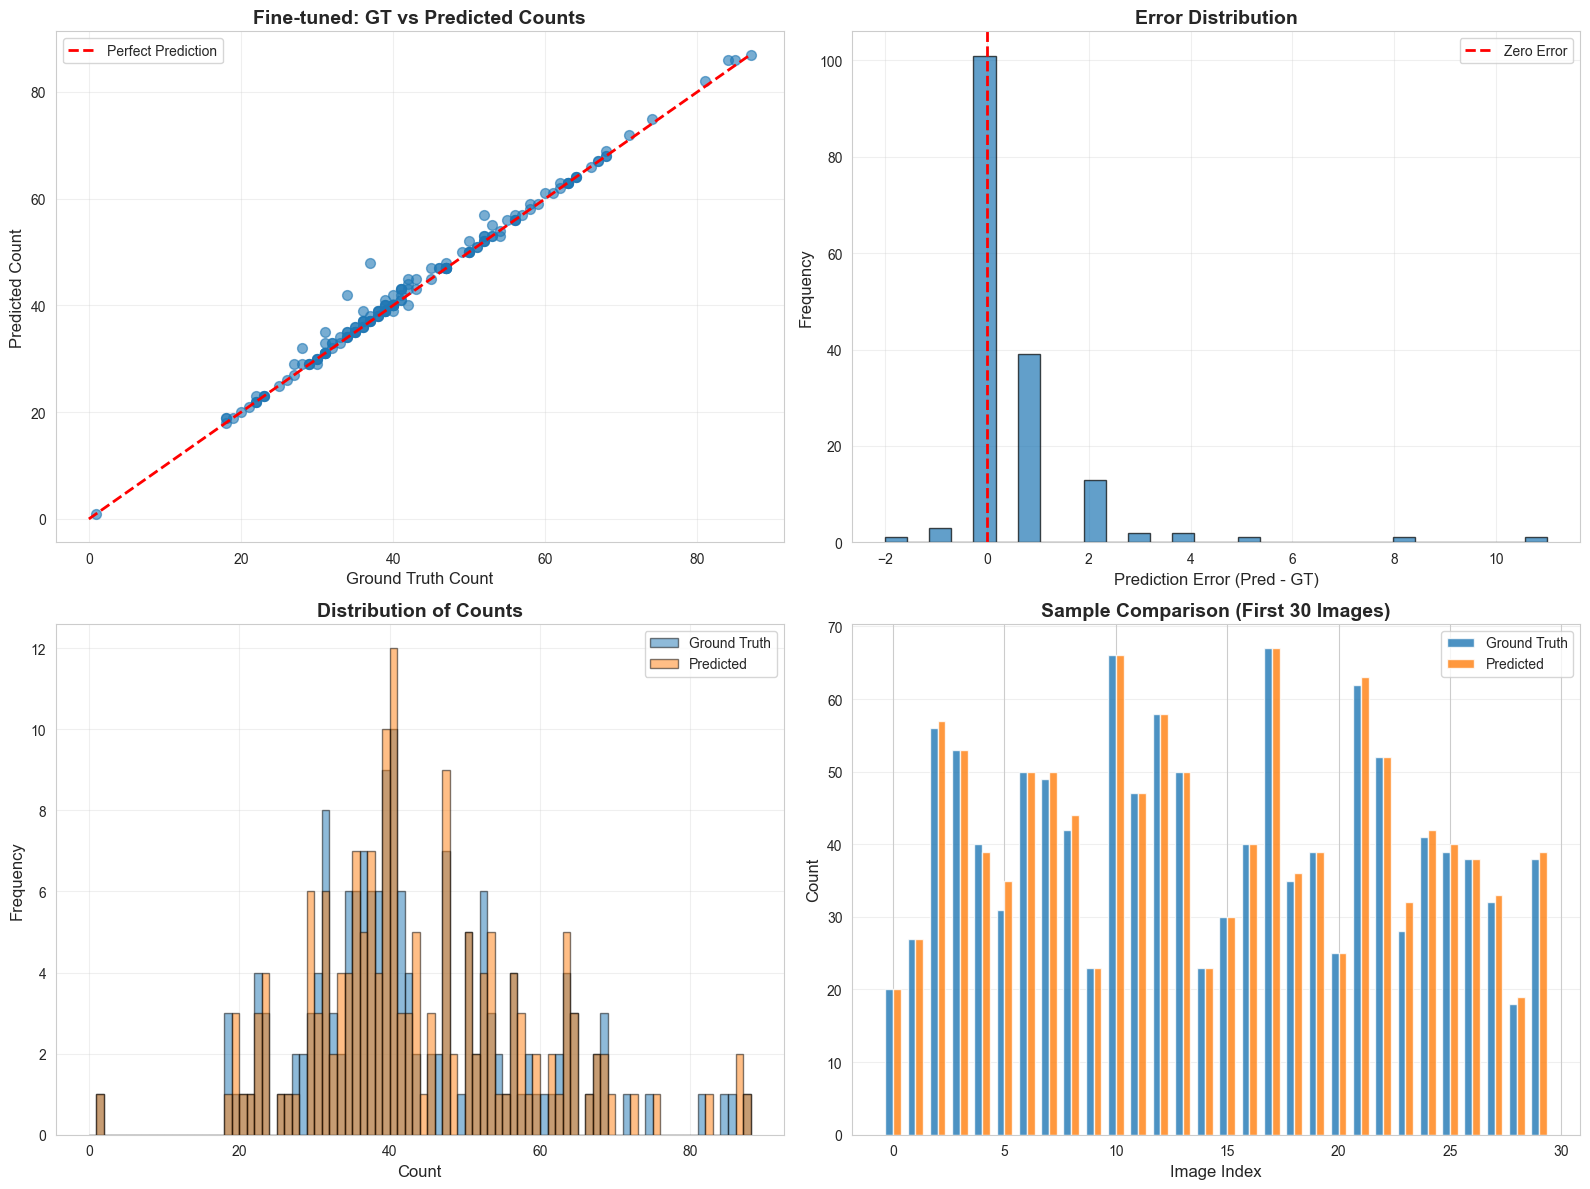

Counting analysis plots saved


In [9]:
# Show counting distribution for fine-tuned model
if 'Fine-tuned' in results and not results['Fine-tuned']['count_df'].empty:
    count_df = results['Fine-tuned']['count_df']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # GT vs Predicted scatter
    ax = axes[0, 0]
    ax.scatter(count_df['gt_count'], count_df['pred_count'], alpha=0.6, s=50)
    max_val = max(count_df['gt_count'].max(), count_df['pred_count'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    ax.set_xlabel('Ground Truth Count', fontsize=12)
    ax.set_ylabel('Predicted Count', fontsize=12)
    ax.set_title('Fine-tuned: GT vs Predicted Counts', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Error distribution
    ax = axes[0, 1]
    ax.hist(count_df['difference'], bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    ax.set_xlabel('Prediction Error (Pred - GT)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Error Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Count distribution
    ax = axes[1, 0]
    bins = np.arange(0, max(count_df['gt_count'].max(), count_df['pred_count'].max()) + 2, 1)
    ax.hist(count_df['gt_count'], bins=bins, alpha=0.5, label='Ground Truth', edgecolor='black')
    ax.hist(count_df['pred_count'], bins=bins, alpha=0.5, label='Predicted', edgecolor='black')
    ax.set_xlabel('Count', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of Counts', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Sample comparison
    ax = axes[1, 1]
    n_samples = min(30, len(count_df))
    x = np.arange(n_samples)
    width = 0.35
    ax.bar(x - width/2, count_df['gt_count'].iloc[:n_samples], width, label='Ground Truth', alpha=0.8)
    ax.bar(x + width/2, count_df['pred_count'].iloc[:n_samples], width, label='Predicted', alpha=0.8)
    ax.set_xlabel('Image Index', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Sample Comparison (First {n_samples} Images)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('yolov9_counting_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Counting analysis plots saved")

## 10. Save Results Summary

In [10]:
results_summary = {}

for model_name, result in results.items():
    results_summary[model_name] = {
        'detection': {
            'map_50_95': float(result['detection'].get('map_50_95', 0)),
            'map_50': float(result['detection'].get('map_50', 0)),
            'precision': float(result['detection'].get('precision', 0)),
            'recall': float(result['detection'].get('recall', 0)),
            'fps': float(result['detection'].get('fps', 0)),
            'inference_ms': float(result['detection'].get('inference_ms', 0))
        },
        'counting': {
            'accuracy': float(result['counting']['count_accuracy']),
            'mae': float(result['counting']['count_mae'])
        },
        'resources': {
            'model_size_mb': float(result['model_size_mb'])
        }
    }

with open('yolov9_comparison_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to 'yolov9_comparison_results.json'")

# Export tables to CSV
df_detection.to_csv('yolov9_detection_comparison.csv', index=False)
df_counting.to_csv('yolov9_counting_comparison.csv', index=False)
df_resources.to_csv('yolov9_resources_comparison.csv', index=False)

print("\nCSV files saved:")
print("  - yolov9_detection_comparison.csv")
print("  - yolov9_counting_comparison.csv")
print("  - yolov9_resources_comparison.csv")

print("\n" + "="*80)
print("YOLOv9 EVALUATION COMPLETE")
print("="*80)
print("\nGenerated files:")
print("  Visualizations:")
print("     - yolov9_detection_comparison.png")
print("     - yolov9_speed_comparison.png")
print("     - yolov9_counting_analysis.png")
print("  Data files:")
print("     - yolov9_comparison_results.json")
print("     - yolov9_detection_comparison.csv")
print("     - yolov9_counting_comparison.csv")
print("     - yolov9_resources_comparison.csv")
print("="*80)

Results saved to 'yolov9_comparison_results.json'

CSV files saved:
  - yolov9_detection_comparison.csv
  - yolov9_counting_comparison.csv
  - yolov9_resources_comparison.csv

YOLOv9 EVALUATION COMPLETE

Generated files:
  Visualizations:
     - yolov9_detection_comparison.png
     - yolov9_speed_comparison.png
     - yolov9_counting_analysis.png
  Data files:
     - yolov9_comparison_results.json
     - yolov9_detection_comparison.csv
     - yolov9_counting_comparison.csv
     - yolov9_resources_comparison.csv
